In [1]:
!pip install soapy

     |████████████████████████████████| 558 kB 4.0 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 2.6 MB 39.2 MB/s 
  Created wheel for soapy: filename=soapy-0.13.2-py3-none-any.whl size=680159 sha256=74ea07c3235cb3cc182c2ff7b8506d5253cd6d8fd2e2da0b3558655ee4bbc4d0
  Stored in directory: /root/.cache/pip/wheels/29/d4/e6/d14f5151c3446422829c31d2944a1837e7e60afbf30514517f
  Created wheel for aotools: filename=aotools-1.0.4-py3-none-any.whl size=39047 sha256=60377aba452152fd6e9115a7cc41edeeed24ba2f841debb17ac915cdc36c40c9
  Stored in directory: /root/.cache/pip/wheels/84/b7/09/7ae0eb742ba851b93d3337c923cf01a2f2557fcb1dd7a6872f
Successfully built soapy aotools


In [2]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
import yaml
import time
import pip
import sys
import soapy
import torchvision.models as models 
import torch.nn as nn
import torch

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Mounted at /content/gdrive


In [ ]:

def loopFrame(sim, new_commands):

    t = time.time()
    sim.scrns = sim.atmos.moveScrns()
    sim.Tatmos = time.time()-t
    sim.dmCommands = new_commands
    sim.closed_correction = sim.runDM(
            sim.dmCommands, closed=True)
    sim.slopes = sim.runWfs(dmShape=sim.closed_correction,
                              loopIter=sim.iters)

    sim.open_correction = sim.runDM(sim.dmCommands,
                                      closed=False)

    sim.combinedCorrection = sim.open_correction + sim.closed_correction
    sim.runSciCams(sim.combinedCorrection)
    sim.storeData(sim.iters)
    sim.printOutput(sim.iters, strehl=True)
    sim.addToGuiQueue()
    sim.iters += 1

In [133]:


class AdaptiveOptics(gym.Env):
    def __init__(self, conf_file=None):
        if conf_file:
            self.conf_file = conf_file
        else:
            self.conf_file = sys.path[-1]+"/sh_8x8.yaml"
        with open(self.conf_file, 'r') as stream:
            self.data_loaded = yaml.safe_load(stream)
        self.__counter = 0
        self.last_reward = -1000
        self.reward = 0
        self.mem_img = []
        self.expert_commands = []
        self.action_space = spaces.Box(-50, 50, shape=(32,))
        self.observation_space = spaces.Box(0, 255, shape=(64, 64,3), dtype=np.uint8)
        self.pre_expert_value = None
        self.expert_value = None
        self.max_reward = 5
        self.min_reward = 0
        self.mean_reward = 0
        self._initao()
    
    def expert(self):
        if self.sim.config.sim.nDM:
            self.sim.dmCommands[:] = self.sim.recon.reconstruct(self.sim.slopes)
        commands = self.sim.buffer.delay(self.sim.dmCommands, self.sim.config.sim.loopDelay)
        return commands

    def _initao(self):
        #self.data_loaded['Atmosphere']['windDirs'] = np.random.randint(0, 180, 4).tolist()
        self.sim = soapy.Sim(self.conf_file)
        self.sim.aoinit()
        self.sim.makeIMat()

        self.mem_img = []
        for i in range(3):
            expert_value = self.expert()
            loopFrame(self.sim, expert_value)
            img = self.sim.sciImgs[0].copy()
            img = ((img - np.min(img)) / (np.max(img) - np.min(img))) * 255
            img = img.astype(np.uint8)
            img = img.reshape(1, 64, 64)
            self.mem_img.append(img)
        self.pre_expert_value = self.expert()

        return np.vstack(self.mem_img).T

    def calc_brightness(self, img):
      return (np.sum(img**2)/(np.sum(img))**2)*100

    def step(self, action):
        loopFrame(self.sim, action)
        
        img = self.sim.sciImgs[0].copy()
        reward = self.calc_brightness(img)
        # reward = (reward-0.3)/(0.6 - 0.3)
        next_state = ((img - np.min(img)) / (np.max(img) - np.min(img)) )* 255
        next_state = next_state.astype(np.uint8)
        x = next_state.reshape(1, 64, 64)
        self.mem_img.append(x)
        state = self.mem_img[:3]
        self.mem_img = self.mem_img[1:]
    
        return np.vstack(state).T, reward.astype(np.float32), False, {}

    def reset(self):
        state = self._initao()
        return state

    def render(self):
        plt.imshow(self.sim.sciImgs[0])
        plt.show()

    def close(self):
        pass



In [134]:
ao_env = AdaptiveOptics( "/content/gdrive/My Drive/ao_prediction/architecture/rl/env/conf/sh_8x8.yaml")

Loading configuration file...
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Loading configuration file... success!
Starting Sim: 2021-08-20-15-24-23
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Making interaction Matrices...
Creating Intera

804 of 10000: sh_8x8  Strehl -- sci_0: inst 0.38, long 0.29 sci_1: inst 0.21, long 0.08 0.49038598
805 of 10000: sh_8x8  Strehl -- sci_0: inst 0.39, long 0.29 sci_1: inst 0.22, long 0.08 0.49059913
806 of 10000: sh_8x8  Strehl -- sci_0: inst 0.39, long 0.29 sci_1: inst 0.22, long 0.08 0.4908072
807 of 10000: sh_8x8  Strehl -- sci_0: inst 0.40, long 0.29 sci_1: inst 0.22, long 0.08 0.491032
808 of 10000: sh_8x8  Strehl -- sci_0: inst 0.40, long 0.29 sci_1: inst 0.23, long 0.08 0.4912847
809 of 10000: sh_8x8  Strehl -- sci_0: inst 0.40, long 0.29 sci_1: inst 0.23, long 0.08 0.4915572
810 of 10000: sh_8x8  Strehl -- sci_0: inst 0.41, long 0.29 sci_1: inst 0.22, long 0.08 0.4918486
811 of 10000: sh_8x8  Strehl -- sci_0: inst 0.41, long 0.29 sci_1: inst 0.22, long 0.08 0.49217895
812 of 10000: sh_8x8  Strehl -- sci_0: inst 0.42, long 0.29 sci_1: inst 0.21, long 0.08 0.49253964
813 of 10000: sh_8x8  Strehl -- sci_0: inst 0.42, long 0.29 sci_1: inst 0.20, long 0.08 0.4929086
814 of 10000: sh_

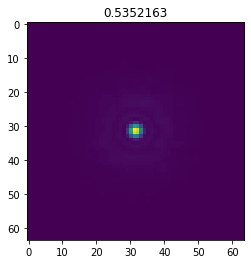

In [137]:
for i in range(1000):
  expert_mark = ao_env.expert()
  state, reward, _, _ = ao_env.step(expert_mark)

  plt.imshow(state[:,:,0])
  plt.title(reward)
  
  print(reward)